# Importing Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Read Dataset

In [4]:
train_data = pd.read_csv('../train.csv')
test_data = pd.read_csv('../test.csv')
submission = pd.read_csv('../sample_submissions.csv')

# EDA

In [5]:
print("--- Info Data Train ---")
train_data.info()

--- Info Data Train ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20012 entries, 0 to 20011
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_transaksi               20012 non-null  int64  
 1   tanggal_pencairan          20012 non-null  object 
 2   provinsi                   20012 non-null  object 
 3   jenis_pinjaman             19543 non-null  object 
 4   status_peminjam            20012 non-null  object 
 5   jumlah_pinjaman            20012 non-null  float64
 6   total_pengembalian         17947 non-null  float64
 7   durasi_hari                19212 non-null  float64
 8   porsi_pengembalian_lender  18052 non-null  float64
 9   sektor_usaha               20012 non-null  object 
 10  pendidikan                 20012 non-null  object 
 11  jenis_jaminan              20012 non-null  object 
 12  status_gagal_bayar         20012 non-null  int64  
dtypes: float64(4), int64(2

Terdapat fitur waktu yang masih berupa object yaitu `tanggal_pencarian`, akan di ekstrak pada tahap preprocessing.

In [6]:
print("\n--- Missing Values (Train) ---")
print(train_data.isnull().sum())


--- Missing Values (Train) ---
id_transaksi                    0
tanggal_pencairan               0
provinsi                        0
jenis_pinjaman                469
status_peminjam                 0
jumlah_pinjaman                 0
total_pengembalian           2065
durasi_hari                   800
porsi_pengembalian_lender    1960
sektor_usaha                    0
pendidikan                      0
jenis_jaminan                   0
status_gagal_bayar              0
dtype: int64


Terlihat cukup banyak kolom yang memiliki missing value, akan ditindaklanjuti pada saat preprocessing

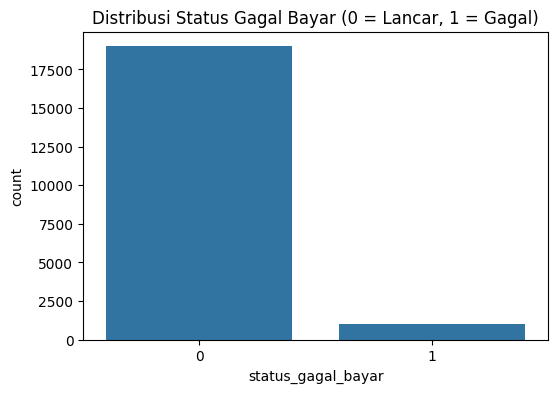

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='status_gagal_bayar', data=train_data)
plt.title('Distribusi Status Gagal Bayar (0 = Lancar, 1 = Gagal)')
plt.show()

Distribusi kolom target yang sangat imbalanced sehingga perlu dilakukan oversampling pada saat preprocessing

In [8]:
porsi_clean = train_data['porsi_pengembalian_lender'].dropna()

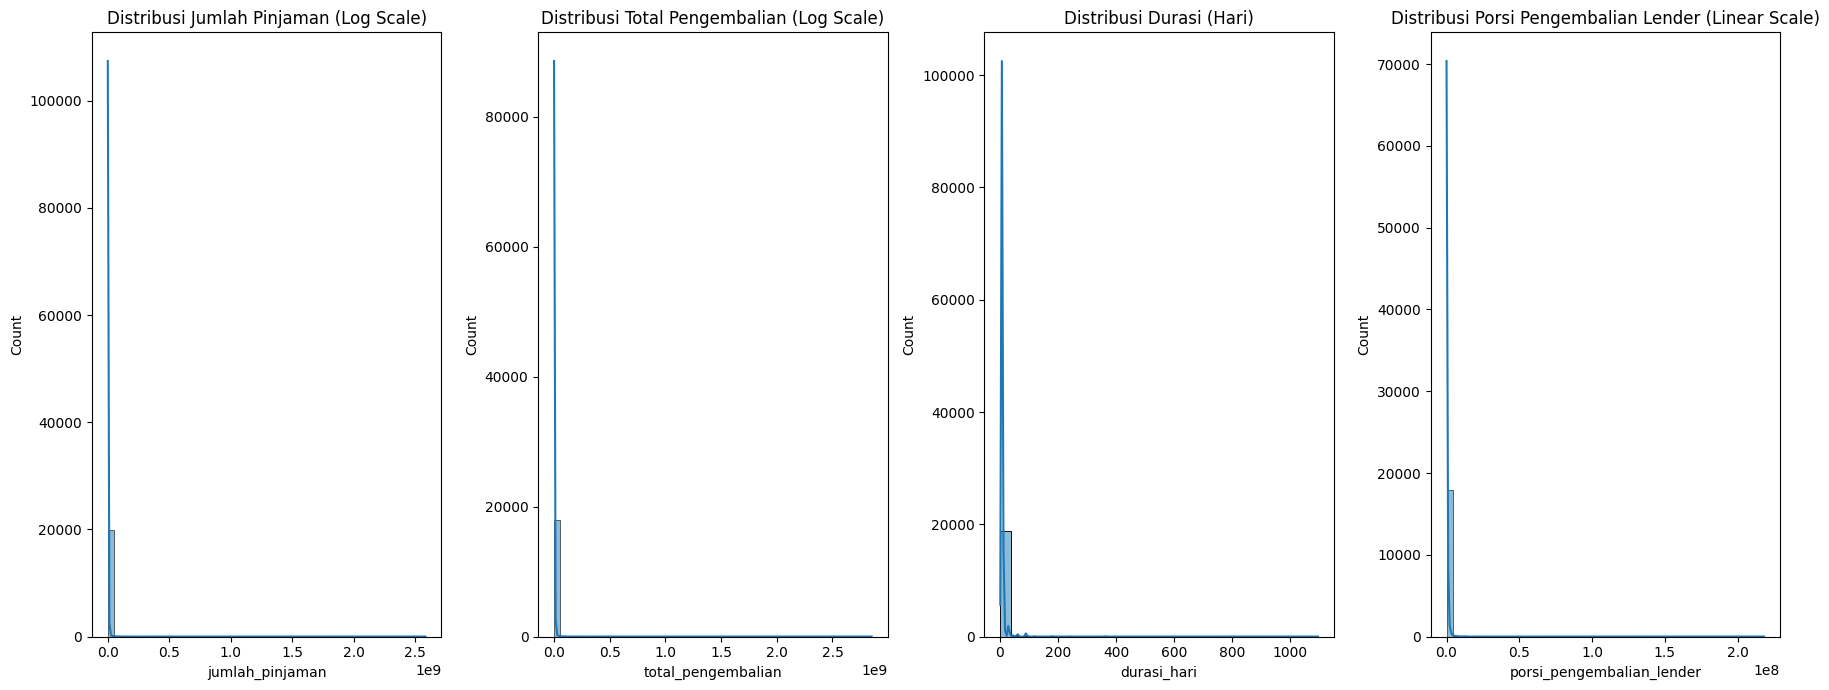

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(18, 7))

sns.histplot(train_data[train_data['jumlah_pinjaman'] > 0]['jumlah_pinjaman'],
             bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribusi Jumlah Pinjaman (Log Scale)')

sns.histplot(train_data[train_data['total_pengembalian'] > 0]['total_pengembalian'],
             bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribusi Total Pengembalian (Log Scale)')

sns.histplot(train_data[train_data['durasi_hari'] > 0]['durasi_hari'],
             bins=30, kde=True, ax=axes[2])
axes[2].set_title('Distribusi Durasi (Hari)')

sns.histplot(porsi_clean, bins=50, kde=True, ax=axes[3])
axes[3].set_title('Distribusi Porsi Pengembalian Lender (Linear Scale)')

plt.tight_layout()
plt.show()

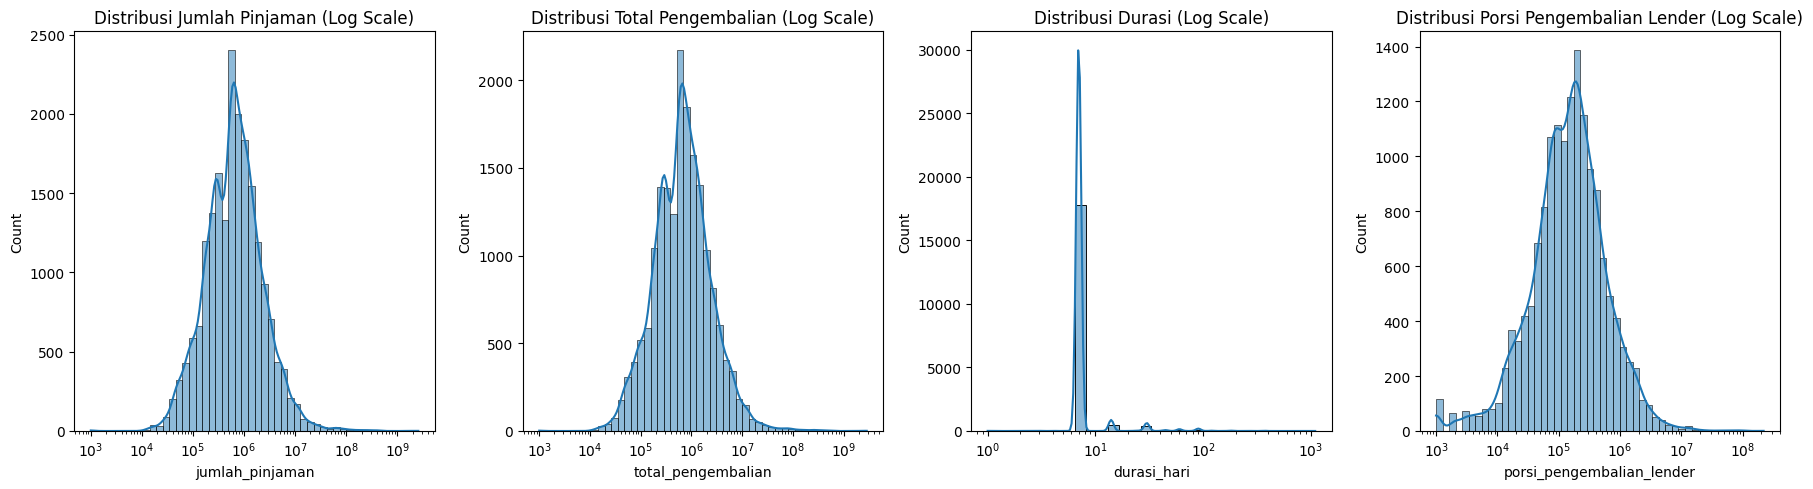

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(train_data[train_data['jumlah_pinjaman'] > 0]['jumlah_pinjaman'],
             bins=50, kde=True, ax=axes[0], log_scale=True)
axes[0].set_title('Distribusi Jumlah Pinjaman (Log Scale)')

sns.histplot(train_data[train_data['total_pengembalian'] > 0]['total_pengembalian'],
             bins=50, kde=True, ax=axes[1], log_scale=True)
axes[1].set_title('Distribusi Total Pengembalian (Log Scale)')

sns.histplot(train_data[train_data['durasi_hari'] > 0]['durasi_hari'],
             bins=30, kde=True, ax=axes[2], log_scale=True)
axes[2].set_title('Distribusi Durasi (Log Scale)')

sns.histplot(porsi_clean[porsi_clean > 0], bins=50, kde=True, ax=axes[3], log_scale=True)
axes[3].set_title('Distribusi Porsi Pengembalian Lender (Log Scale)')

plt.tight_layout()
plt.show()

Ini hasil distribusi dari fitur numerik `jumlah_pinjaman`, `total_pengembalian`, `durasi_hari` dan `porsi_pengambalian_lender`
setelah dilakukan transformasi log, untuk menormalkan distribusi pada data yang mengalami `skewness` ekstrim.

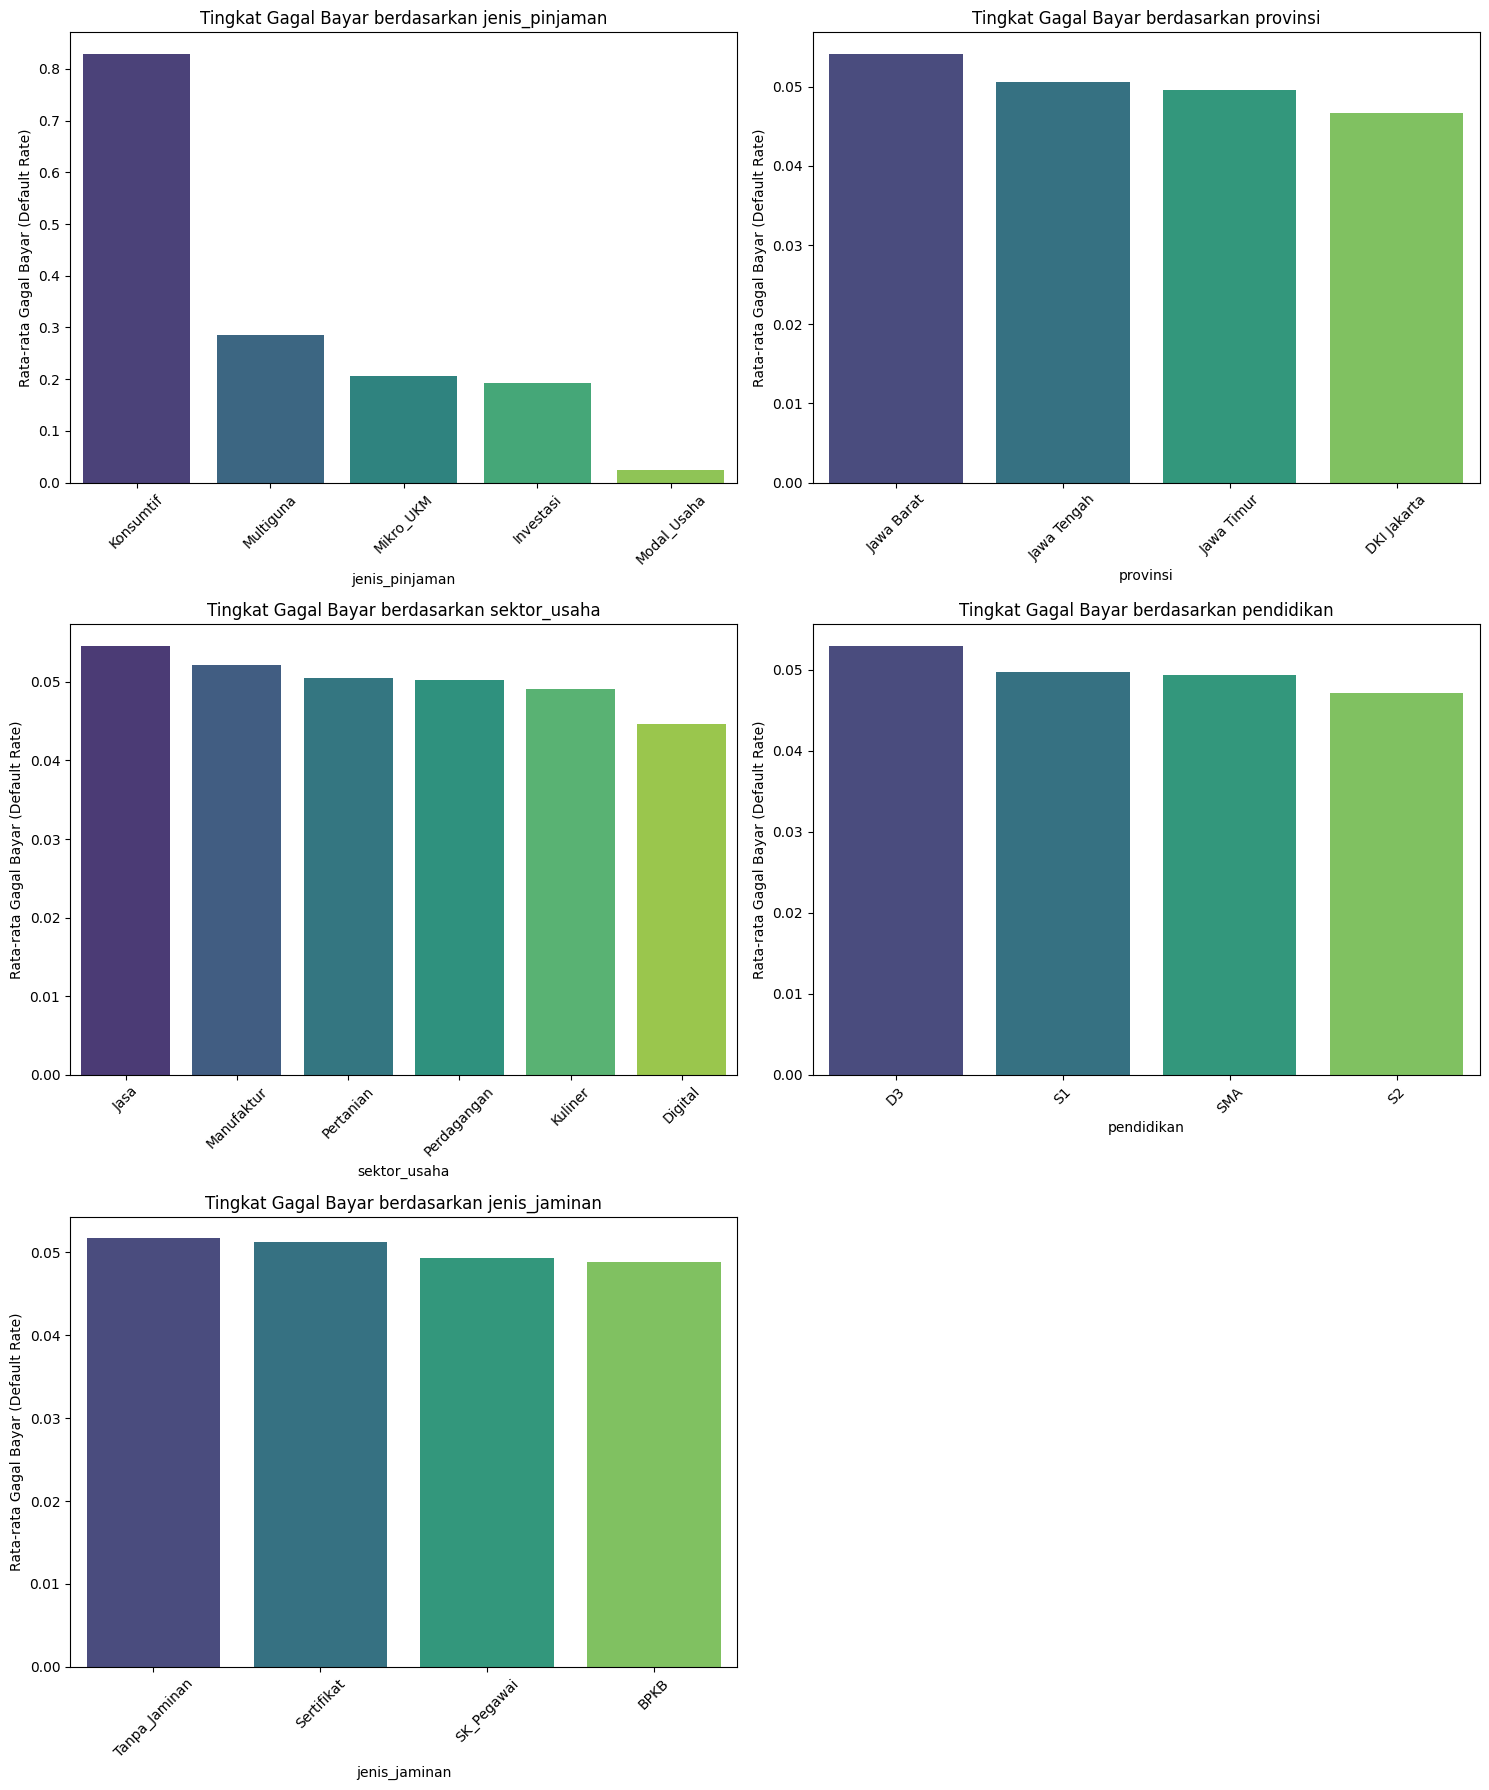

In [11]:
categorical_cols = ['jenis_pinjaman', 'provinsi', 'sektor_usaha', 'pendidikan', 'jenis_jaminan']
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Menghitung rata-rata default per kategori
    default_rate = train_data.groupby(col)['status_gagal_bayar'].mean().sort_values(ascending=False)

    sns.barplot(x=default_rate.index, y=default_rate.values, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Tingkat Gagal Bayar berdasarkan {col}')
    axes[i].set_ylabel('Rata-rata Gagal Bayar (Default Rate)')
    axes[i].tick_params(axis='x', rotation=45)

# Hapus subplot kosong terakhir
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Terlihat bahwa data dengan `jenis_pinjaman` konsumtif menjadi spotlight dikarenakan memiliki pengaruh besar dalam `status_gagal_bayar`

In [12]:
print("\n--- Detail Default Rate per Jenis Pinjaman ---")
print(train_data.groupby('jenis_pinjaman')['status_gagal_bayar'].agg(['mean', 'count']).sort_values(by='mean', ascending=False))

print("\n--- Cek Anomali Durasi ---")
print(f"Jumlah data dengan durasi negatif: {len(train_data[train_data['durasi_hari'] < 0])}")


--- Detail Default Rate per Jenis Pinjaman ---
                    mean  count
jenis_pinjaman                 
Konsumtif       0.829268     41
Multiguna       0.285714    413
Mikro_UKM       0.206935    894
Investasi       0.192534    509
Modal_Usaha     0.024256  17686

--- Cek Anomali Durasi ---
Jumlah data dengan durasi negatif: 200


# Preprocessing

## Feature Engineering

In [13]:
train_data['is_train'] = 1
test_data['is_train'] = 0
test_data['status_gagal_bayar'] = np.nan

full_data = pd.concat([train_data, test_data], ignore_index=True)

In [14]:
def safe_divide(a, b, default=0):
    return np.where(b != 0, a / b, default)

# Extracting Date Features
full_data['tanggal_pencairan'] = pd.to_datetime(full_data['tanggal_pencairan'])
full_data['tahun'] = full_data['tanggal_pencairan'].dt.year
full_data['bulan'] = full_data['tanggal_pencairan'].dt.month
full_data['hari'] = full_data['tanggal_pencairan'].dt.day
full_data['hari_minggu'] = full_data['tanggal_pencairan'].dt.dayofweek
full_data['minggu_tahun'] = full_data['tanggal_pencairan'].dt.isocalendar().week.astype(int)
full_data['kuartal'] = full_data['tanggal_pencairan'].dt.quarter
full_data['awal_bulan'] = (full_data['hari'] <= 10).astype(int)
full_data['akhir_bulan'] = (full_data['hari'] >= 21).astype(int)
full_data['is_weekend'] = (full_data['hari_minggu'] >= 5).astype(int)
full_data['durasi_pinjaman_hari'] = (pd.to_datetime("2025-01-01") - full_data['tanggal_pencairan']).dt.days

full_data.drop('tanggal_pencairan', axis=1, inplace=True)

# Financial ratios (same as original)
full_data['rasio_bunga'] = safe_divide(full_data['total_pengembalian'], full_data['jumlah_pinjaman'])
full_data['beban_harian'] = safe_divide(full_data['total_pengembalian'], full_data['durasi_pinjaman_hari'])
full_data['selisih_pengembalian'] = full_data['total_pengembalian'] - full_data['jumlah_pinjaman']
full_data['suku_bunga_aprox'] = safe_divide(
    full_data['total_pengembalian'] - full_data['jumlah_pinjaman'],
    full_data['jumlah_pinjaman']
)

# Log transforms
full_data['jumlah_pinjaman_log'] = np.log1p(full_data['jumlah_pinjaman'].clip(lower=0))
full_data['total_pengembalian_log'] = np.log1p(full_data['total_pengembalian'].clip(lower=0))

# Polynomial features
full_data['jumlah_pinjaman_sq'] = full_data['jumlah_pinjaman'] ** 2

print(f"Total features: {full_data.shape[1]}")

Total features: 30


Menerapkan feature engineering untuk dataset train dan test.

## Handling Missing Value

In [15]:
numeric_cols = full_data.select_dtypes(include=['number']).columns.tolist()
categorical_cols = full_data.select_dtypes(include=['object']).columns.tolist()

exclude_cols = ['status_gagal_bayar', 'id_transaksi', 'is_train']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

full_data[numeric_cols] = full_data[numeric_cols].replace([np.inf, -np.inf], np.nan)

for col in numeric_cols:
    upper_limit = full_data[col].quantile(0.999)
    lower_limit = full_data[col].quantile(0.001)
    full_data[col] = full_data[col].clip(lower=lower_limit, upper=upper_limit)

imputer_num = SimpleImputer(strategy='median')
full_data[numeric_cols] = imputer_num.fit_transform(full_data[numeric_cols])

Menerapkan imputasi data numerik yang hilang di dataset train dan test

In [16]:
label_encoders = {}
for col in categorical_cols:
    full_data[col] = full_data[col].astype(str)
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col])
    label_encoders[col] = le

Menerapkan encoding untuk fitur kategorikal.

## Splitting Data Train - Validation

In [17]:
train_clean = full_data[full_data['is_train'] == 1].copy()
test_clean = full_data[full_data['is_train'] == 0].copy()

train_clean.drop(['is_train', 'id_transaksi'], axis=1, inplace=True)
test_ids = test_clean['id_transaksi']
test_clean.drop(['is_train', 'id_transaksi', 'status_gagal_bayar'], axis=1, inplace=True)

X = train_clean.drop('status_gagal_bayar', axis=1)
y = train_clean['status_gagal_bayar'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}")

Training: 16009, Validation: 4003


## Oversampling Data Train

In [18]:
minority_indices = y_train[y_train == 1].index
majority_count = len(y_train[y_train == 0])

n_minority_needed = int(majority_count * 0.5)
oversampled_indices = np.random.choice(minority_indices, size=n_minority_needed, replace=True)

X_train_balanced = pd.concat([X_train, X_train.loc[oversampled_indices]])
y_train_balanced = pd.concat([y_train, y_train.loc[oversampled_indices]])

print(f"Before: {dict(y_train.value_counts())}")
print(f"After: {dict(y_train_balanced.value_counts())}")

Before: {0: 15204, 1: 805}
After: {0: 15204, 1: 8407}


Melakukan oversampling untuk data train tanpa melibatkan data validasi dengan tujuan supaya data validasi tetap valid.

# Training Model

In [ ]:
models = {}
results = {}

# 1. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['RandomForest'] = rf_model

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=10,
    random_state=RANDOM_STATE
)
gb_model.fit(X_train_balanced, y_train_balanced)
models['GradientBoosting'] = gb_model

# 3. Extra Trees
et_model = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
et_model.fit(X_train_balanced, y_train_balanced)
models['ExtraTrees'] = et_model

# 4. XGBoost
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0,
    min_child_weight=3,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb_model

# 5. LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0,
    min_child_samples=20,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    verbose=-1
)
lgbm_model.fit(X_train_balanced, y_train_balanced)
models['LightGBM'] = lgbm_model

# 6. CatBoost
catboost_model = CatBoostClassifier(
    iterations=400,
    depth=7,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    random_state=RANDOM_STATE,
    verbose=False
)
catboost_model.fit(X_train_balanced, y_train_balanced)
models['CatBoost'] = catboost_model

  File "C:\Users\irfan\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


## Evaluating Model

In [20]:
print(f"{'Model':<18} {'Accuracy':<12} {'F1 Macro':<12} {'F1 Class1':<12} {'ROC-AUC':<12}")

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_class1 = f1_score(y_val, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_val, y_proba)

    results[name] = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_class1': f1_class1,
        'roc_auc': roc_auc
    }

    print(f"{name:<18} {acc:<12.4f} {f1_macro:<12.4f} {f1_class1:<12.4f} {roc_auc:<12.4f}")

Model              Accuracy     F1 Macro     F1 Class1    ROC-AUC     
RandomForest       0.9848       0.9180       0.8440       0.9884      
GradientBoosting   0.9860       0.9249       0.8571       0.9881      
ExtraTrees         0.9825       0.9075       0.8241       0.9859      
XGBoost            0.9848       0.9184       0.8448       0.9851      
LightGBM           0.9833       0.9104       0.8295       0.9842      
CatBoost           0.9848       0.9188       0.8456       0.9866      


Terlihat bahwa F1 Macro setiap model memiliki nilai yang berbeda-beda

## Stacking Model

In [21]:
estimators = [
    ('rf', models['RandomForest']),
    ('gb', models['GradientBoosting']),
    ('et', models['ExtraTrees']),
    ('xgb', models['XGBoost']),
    ('lgbm', models['LightGBM']),
    ('catboost', models['CatBoost']),
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000, C=0.5),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_balanced, y_train_balanced)

y_pred_stack = stacking_model.predict(X_val)
y_proba_stack = stacking_model.predict_proba(X_val)[:, 1]

stack_acc = accuracy_score(y_val, y_pred_stack)
stack_f1 = f1_score(y_val, y_pred_stack, average='macro')
stack_f1_c1 = f1_score(y_val, y_pred_stack, pos_label=1)
stack_auc = roc_auc_score(y_val, y_proba_stack)

print(f"{'Stacking(6)':<18} {stack_acc:<12.4f} {stack_f1:<12.4f} {stack_f1_c1:<12.4f} {stack_auc:<12.4f}")

Stacking(6)        0.9858       0.9199       0.8472       0.9881      


Proses stacking digunakan untuk membuat model lebih kuat dan bisa menangkap pola yang tidak terdeteksi oleh satu model dan model lainnya.

In [22]:
probas = {name: model.predict_proba(X_val)[:, 1] for name, model in models.items()}

weights = {name: results[name]['f1_macro'] ** 2 for name in models.keys()}
total_w = sum(weights.values())
weights = {k: v/total_w for k, v in weights.items()}

print("Weights:", {k: f"{v:.3f}" for k, v in sorted(weights.items(), key=lambda x: x[1], reverse=True)})

y_proba_blend = sum(weights[name] * probas[name] for name in models.keys())


Weights: {'GradientBoosting': '0.170', 'CatBoost': '0.168', 'XGBoost': '0.167', 'RandomForest': '0.167', 'LightGBM': '0.165', 'ExtraTrees': '0.163'}


In [23]:
best_threshold_stack = 0.5
best_f1_stack = 0
best_threshold_blend = 0.5
best_f1_blend = 0

thresholds = np.arange(0.15, 0.55, 0.01)

for thresh in thresholds:
    # Stacking
    y_pred_t = (y_proba_stack >= thresh).astype(int)
    f1_t = f1_score(y_val, y_pred_t, average='macro')
    if f1_t > best_f1_stack:
        best_f1_stack = f1_t
        best_threshold_stack = thresh

    # Blend
    y_pred_b = (y_proba_blend >= thresh).astype(int)
    f1_b = f1_score(y_val, y_pred_b, average='macro')
    if f1_b > best_f1_blend:
        best_f1_blend = f1_b
        best_threshold_blend = thresh

print(f"Stacking optimal threshold: {best_threshold_stack:.2f} (F1: {best_f1_stack:.4f})")
print(f"Blend optimal threshold: {best_threshold_blend:.2f} (F1: {best_f1_blend:.4f})")

Stacking optimal threshold: 0.19 (F1: 0.9270)
Blend optimal threshold: 0.49 (F1: 0.9249)


In [24]:
# Choose best approach
if best_f1_stack >= best_f1_blend:
    best_proba = y_proba_stack
    best_threshold = best_threshold_stack
    best_method = "Stacking"
else:
    best_proba = y_proba_blend
    best_threshold = best_threshold_blend
    best_method = "Blend"

print(f"\nBest method: {best_method}")


Best method: Stacking


In [25]:
y_pred_final = (best_proba >= best_threshold).astype(int)

print("\n" + "=" * 70)
print(f"FINAL RESULTS ({best_method})")
print("=" * 70)
print(f"Accuracy:    {accuracy_score(y_val, y_pred_final):.4f}")
print(f"F1 Macro:    {f1_score(y_val, y_pred_final, average='macro'):.4f}")
print(f"F1 Class 1:  {f1_score(y_val, y_pred_final, pos_label=1):.4f}")
print(f"ROC-AUC:     {roc_auc_score(y_val, best_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_final))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred_final)
print(cm)


FINAL RESULTS (Stacking)
Accuracy:    0.9868
F1 Macro:    0.9270
F1 Class 1:  0.8609
ROC-AUC:     0.9881

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3802
           1       0.91      0.82      0.86       201

    accuracy                           0.99      4003
   macro avg       0.95      0.91      0.93      4003
weighted avg       0.99      0.99      0.99      4003

Confusion Matrix:
[[3786   16]
 [  37  164]]


Dari hasil yang didapatkan adalah F1 Macro sebesar 0.9270 meskipun dengan proporsi yang berbeda untuk tiap target.

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_xgb = cross_val_score(models['XGBoost'], X, y, cv=skf, scoring='f1_macro')
cv_lgbm = cross_val_score(models['LightGBM'], X, y, cv=skf, scoring='f1_macro')
cv_catboost = cross_val_score(models['CatBoost'], X, y, cv=skf, scoring='f1_macro')
cv_gb = cross_val_score(models['GradientBoosting'], X, y, cv=skf, scoring='f1_macro')

print(f"XGBoost CV:          {cv_xgb.mean():.4f} ± {cv_xgb.std():.4f}")
print(f"LightGBM CV:         {cv_lgbm.mean():.4f} ± {cv_lgbm.std():.4f}")
print(f"CatBoost CV:         {cv_catboost.mean():.4f} ± {cv_catboost.std():.4f}")
print(f"GradientBoosting CV: {cv_gb.mean():.4f} ± {cv_gb.std():.4f}")

XGBoost CV:          0.9239 ± 0.0088
LightGBM CV:         0.9144 ± 0.0157
CatBoost CV:         0.9286 ± 0.0086
GradientBoosting CV: 0.9280 ± 0.0111


In [27]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

                  feature  importance
              rasio_bunga    0.282161
         suku_bunga_aprox    0.262312
     selisih_pengembalian    0.134158
     durasi_pinjaman_hari    0.042692
              durasi_hari    0.042377
           jenis_pinjaman    0.035390
                    tahun    0.020443
porsi_pengembalian_lender    0.018416
             beban_harian    0.018287
       jumlah_pinjaman_sq    0.016510
             minggu_tahun    0.016396
      jumlah_pinjaman_log    0.016300
          jumlah_pinjaman    0.015767
       total_pengembalian    0.013799
   total_pengembalian_log    0.012495


Ini adalah 15 fitur yang terpenting dalam artian yang memiliki pengaruh besar dalam menentukan hasil.

# Submission

In [28]:
test_proba_stack = stacking_model.predict_proba(test_clean)[:, 1]

test_pred_stack = (test_proba_stack >= best_threshold_stack).astype(int)
sub_stack = submission.copy()
sub_stack['status_gagal_bayar'] = test_pred_stack
sub_stack.to_csv('submission_stacking6.csv', index=False)
print(f"submission_stacking6.csv - {dict(pd.Series(test_pred_stack).value_counts())}")

submission_stacking6.csv - {0: 4735, 1: 268}


# Submission

In [31]:
import joblib

saved_data = {
    "model": stacking_model,
    "encoders": label_encoders,
    "imputer": imputer_num
}

filename = 'Model1_SakitLearn_ADIKARA2025.pkl'
joblib.dump(saved_data, filename)

['Model1_SakitLearn_ADIKARA2025.pkl']